In [3]:
# import package
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import IPython.display
from IPython.display import display, Markdown, clear_output

import plotly.graph_objects as go
from datetime import datetime

2023-10-05 20:29:11.386161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 20:29:12.182329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
ticker = yf.Ticker('BTC-USD')
btc = ticker.history(period="max")
btc.head()

timesteps = btc.index.to_numpy()
prices = btc["Close"].to_numpy()

In [5]:
split_size = int(0.8 * len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

(2644, 662, 2644, 662)

In [7]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):

    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price")
    if label:
        plt.legend(fontsize=15)
    plt.grid(True)

In [8]:
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    return mae / mae_naive_no_season

In [9]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [10]:
HORIZON = 1
WINDOW_SIZE = 7

In [11]:
def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

In [12]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))

Window: [0 1 2 3 4 5 6] -> Label: 7


2023-10-05 20:29:14.396707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 20:29:14.430638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 20:29:14.430901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):

    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    windowed_array = x[window_indexes]

    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [14]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

(3299, 3299)

In [16]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [17]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

(2639, 660, 2639, 660)

In [19]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor="val_loss",
                                              verbose=0,
                                              save_best_only=True)

In [20]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

# LSTM Model


In [21]:
from tensorflow.keras import layers

HORIZON = 1
WINDOW_SIZE = 7

# Set seed
tf.random.set_seed(42)


# build an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
lstm_model = tf.keras.Model(inputs=inputs, outputs=output, name="lstm_model_saved")

# Compile the model
lstm_model.compile(loss="mae",
                   optimizer=tf.keras.optimizers.legacy.Adam())

# Fit the model
lstm_model.fit(train_windows,
              train_labels,
              epochs=100,
              verbose=0,
              batch_size=128,
              validation_data=(test_windows, test_labels),
              callbacks=[create_model_checkpoint(model_name=lstm_model.name)])

INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model_saved/assets


In [22]:
lstm_model = tf.keras.models.load_model("model_experiments/lstm_model_saved")
lstm_model.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 1ms/step - loss: 612.7951


612.7951049804688

In [23]:
lstm_model_preds = make_preds(lstm_model, test_windows)
lstm_model_preds[:5]

21/21 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47050.42 , 48224.254, 47773.72 , 46659.223, 46717.246],
      dtype=float32)>

In [24]:
lstm_model_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                    y_pred=lstm_model_preds)
lstm_model_results

{'mae': 612.7953,
 'mse': 888674.06,
 'rmse': 942.69507,
 'mape': 2.1496265,
 'mase': 1.1165595}

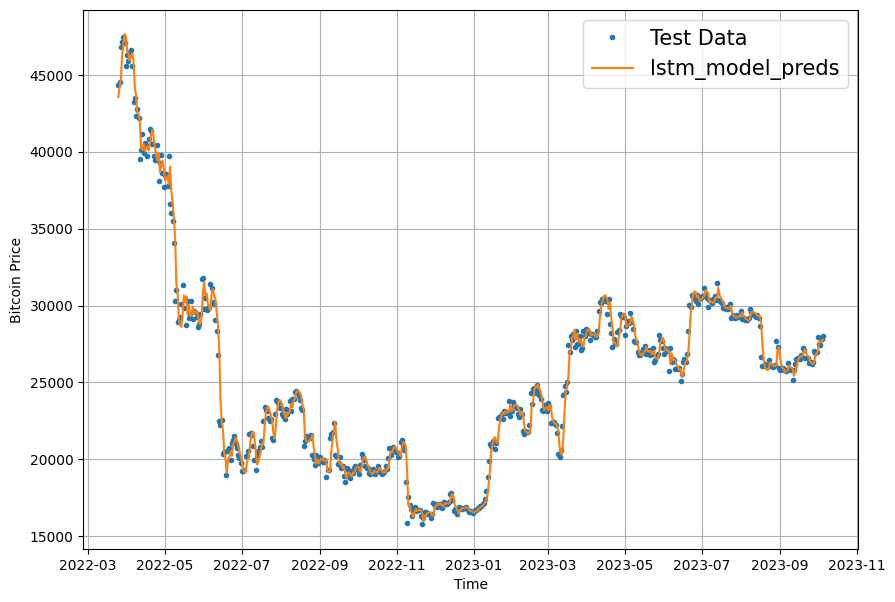

In [25]:
offset = 100
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                      values=test_labels[:, 0],
                      start=offset,
                      label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                      values=lstm_model_preds,
                      start=offset,
                      format="-",
                      label="lstm_model_preds")
